1. Deep learning neural networks are capable of automatically learning and extracting features from raw data. 
2. simple deep learning neural network models are capable of making skillful forecasts as compared to naive models and tuned SARIMA models on univariate time series forecasting problems that have both trend and seasonal components with no pre-processing.

After completing this tutorial, you will know:
- How to develop a robust test harness using walk-forward validation for evaluating the performance of neural network models.
- How to develop and evaluate simple Multilayer Perceptron and convolutional neural networks for time series forecasting.
- How to develop and evaluate LSTMs, CNN-LSTMs, and ConvLSTM neural network models for time series forecasting.


## 14.1 Tutorial Overview
This tutorial is divided into five parts; they are: 
1. Time Series Problem
2. Model Evaluation Test Harness
3. Multilayer Perceptron Model
4. Convolutional Neural Network Model 
5. Recurrent Neural Network Models

## 14.2 Time Series Problem
- We will use the monthly car sales dataset as this context as it includes the complexity of both trend and seasonal elements. The monthly car sales dataset summarizes the monthly car sales in Quebec, Canada between 1960 and 1968. 
- The dataset is monthly and has nine years, or 108 observations. In our testing, will use the last year, or 12 observations, as the test set. 
- The dataset has an obvious trend and seasonal component. The period of the seasonal component could be six months or 12 months.

## 14.3 Model Evaluation Test Harness

This test harness is a modified version of the framework presented in Chapter 11 and may cover much of the same of the same ground. This section is divided into the following parts:
1. Train-Test Split
2. Series as Supervised Learning
3. Walk-Forward Validation
4. Repeat Evaluation
5. Summarize Performance 
6. Worked Example

### 14.3.1 Train-Test Split

### 14.3.2 Series as Supervised Learning
A supervised learning framing of a series means that the data needs to be split into multiple examples that the model learn from and generalize across. Each sample must have both an input component and an output component. The input component will be some number of prior observations, such as three years or 36 time steps.

### 14.3.3 Walk-Forward Validation


### 14.3.4 Repeat Evaluation

### 14.3.5 Summarize Performance

### 14.3.6 Worked Example

we will calculate the median of a subset of prior observations relative to the time to be forecasted. We do not need to fit a model so the model fit() function will be implemented to simply return None.

 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
persistence: 1841.156 RMSE (+/- 0.000)


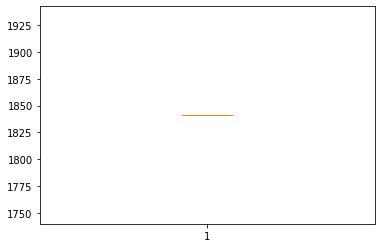

In [1]:
# persistence forecast for monthly car sales dataset
from math import sqrt
from numpy import median
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
%matplotlib inline

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
	return None

# forecast with a pre-fit model
def model_predict(model, history, config):
	values = list()
	for offset in config:
		values.append(history[-offset])
	return median(values)

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [12, 24, 36]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('persistence', scores)

We can see that the RMSE of the model is 1841 sales, providing a lower-bound of performance by which we can evaluate whether a model is skillful or not on the problem. 

## 14.4 Multilayer Perceptron Model

- The first network that we will evaluate is a Multilayer Perceptron, or MLP for short. This is a simple feedforward neural network model that should be evaluated before more elaborate models are considered. 
- MLPs can be used for time series forecasting by taking multiple observations at prior time steps, called lag observations, and using them as input features and predicting one or more time steps from those observations. This is exactly the framing of the problem provided by the series to supervised() function in the previous section. 

X,  &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;y <br>
month1, month2, month3, month4 <br>
month2, month3, month4, month5 <br>
month3, month4, month5, month6 <br>

The model fit() function for fitting an MLP model on the training dataset is listed below. The function expects the config to be a list with the following configuration hyperparameters:
- n input: The number of lag observations to use as input to the model.
- n nodes: The number of nodes to use in the hidden layer.
- n epochs: The number of times to expose the model to the whole training dataset.
- n batch: The number of samples within an epoch after which the weights are updated.

Note that when the training data is framed as a supervised learning problem, there are only 72 samples that can be used to train the model. Using a batch size of 72 or more means that the model is being trained using batch gradient descent instead of mini-batch gradient descent.

/Users/Jianhua/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
W0620 17:28:39.704894 4516132288 deprecation_wrapper.py:118] From /Users/Jianhua/anaconda/lib/python3.6/site-packages/tensorflow/__init__.py:99: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0620 17:28:39.705780 4516132288 deprecation_wrapper.py:118] From /Users/Jianhua/anaconda/lib/python3.6/site-packages/tensorflow/__init__.py:99: The name tf.AttrValue is deprecated. Please use tf.compat.v1.AttrValue instead.

W0620 17:28:39.707077 4516132288 deprecation_wrapper.py:118] From /Users/Jianhua/anaconda/lib/python3.6/site-packages/tensorflow/__init__.py:99: The name tf.COMPILER_VERSION is deprecated. Please use tf.

 > 1578.923
 > 1560.381
 > 1373.395
 > 1739.538
 > 1761.065
 > 1559.661
 > 1699.333
 > 1586.307
 > 1595.143
 > 1695.266
 > 1515.707
 > 1524.551
 > 1550.607
 > 1623.120
 > 1504.344
 > 1546.014
 > 1461.201
 > 1383.940
 > 1806.006
 > 1609.717
 > 1560.840
 > 1367.168
 > 1454.874
 > 1449.245
 > 1317.731
 > 2051.709
 > 1706.215
 > 1370.686
 > 1326.256
 > 1486.264
mlp: 1558.840 RMSE (+/- 157.060)


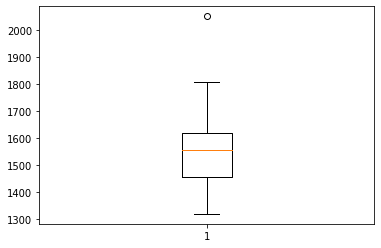

In [2]:
# evaluate mlp for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch = config
	# prepare data
	data = series_to_supervised(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	# define model
	model = Sequential()
	model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape(1, n_input)
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [24, 500, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('mlp', scores)

We can see that although on average the performance of the model is impressive, the spread is large. The standard deviation is a little more than 134 sales, meaning a worse case model run that is 2 or 3 standard deviations in error from the mean error may be worse than the naive model. A challenge in using the MLP model is in harnessing the higher skill and minimizing the variance of the model across multiple runs.

## 14.5 Convolutional Neural Network Model


1. We will define a CNN with two convolutional layers for extracting features from the input sequences. Each will have a configurable number of filters and kernel size and will use the rectified linear activation function. The number of filters determines the number of parallel fields on which the weighted inputs are read and projected. The kernel size defines the number of time steps read within each snapshot as the network reads along the input sequence.

2. The CNN model expects input data to be in the form of multiple samples, where each sample has multiple input time steps, the same as the MLP in the previous section. One difference is that the CNN can support multiple features or types of observations at each time step, which are interpreted as channels of an image. We only have a single feature at each time step, therefore the required three-dimensional shape of the input data will be [n samples, n input, 1].

3. The model fit() function for fitting the CNN model on the training dataset is listed below. The model takes the following five configuration parameters as a list:
   - n_input: The number of lag observations to use as input to the model.
   - n_filters: The number of parallel filters.
   - n_kernel: The number of time steps considered in each read of the input sequence.
   - n_epochs: The number of times to expose the model to the whole training dataset.
   - n_batch: The number of samples within an epoch after which the weights are updated.
   
4. Making a prediction with the fit CNN model is very much like making a prediction with the fit MLP model in the previous section. The one difference is in the requirement that we specify the number of features observed at each time step, which in this case is 1.

W0620 18:09:44.556500 4516132288 deprecation_wrapper.py:118] From /Users/Jianhua/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



 > 1612.899
 > 1508.631
 > 1511.113
 > 1580.887
 > 1544.531
 > 1455.062
 > 1488.155
 > 1588.717
 > 1473.459
 > 1511.153
 > 1609.956
 > 1541.240
 > 1510.402
 > 1565.353
 > 1486.451
 > 1600.393
 > 1656.380
 > 1518.757
 > 1422.331
 > 1658.227
 > 1440.192
 > 1513.167
 > 1485.856
 > 1447.541
 > 1604.083
 > 1487.400
 > 1495.686
 > 1520.420
 > 1545.942
 > 1491.291
cnn: 1529.189 RMSE (+/- 60.935)


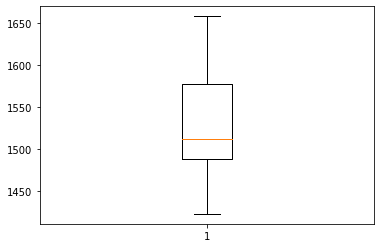

In [3]:
# evaluate cnn  for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = []
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_filters, n_kernel, n_epochs, n_batch = config
	# prepare data
	data = series_to_supervised(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, 1)))
	model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = []
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [36, 256, 3, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn', scores)

A box and whisker plot of the scores is created to help understand the spread of error across the runs. We can see that the spread does seem to be biased towards larger error values, as we would expect, although the upper whisker of the plot (in this case, the largest error that are not outliers) is still limited at an RMSE of 1,650 sales.

## 14.6 Recurrent Neural Network Models

LSTM achieves this by learning the weights for internal gates that control the recurrent connections within each node. Although developed for sequence data, LSTMs have not proven effective on time series forecasting problems where the output is a function of recent observations, e.g. an autoregressive type forecasting problem, such as the car sales dataset.

In this section, we will explore three variations on the LSTM model for univariate time series forecasting; they are:
- Vanilla LSTM: The LSTM network as-is.
- CNN-LSTM: A CNN network that learns input features and an LSTM that interprets them.
- ConvLSTM: A combination of CNNs and LSTMs where the LSTM units read input data using the convolutional process of a CNN.

### 14.6.1 LSTM

1. The LSTM has an internal memory allowing it to accumulate internal state as it reads across the steps of a given input sequence. At the end of the sequence, each node in a layer of hidden LSTM units will output a single value. This vector of values summarizes what the LSTM learned or extracted from the input sequence. 
2. Like the CNN, the LSTM can support multiple variables or features at each time step.
3. Unlike the MLP and CNN that do not read the sequence data one-step at a time, the LSTM does perform better if the data is stationary. This means that difference operations are performed to remove the trend and seasonal structure. In the case of the car sales dataset, we can make the data stationery by performing a seasonal adjustment, that is subtracting the value from one year ago from each observation.
4. The model expects a list of five model hyperparameters; they are:
   - n_input: The number of lag observations to use as input to the model.
   - n_nodes: The number of LSTM units to use in the hidden layer. so it is the hidden state's dimention
   - n_epochs: The number of times to expose the model to the whole training dataset.
   - n_batch: The number of samples within an epoch after which the weights are updated. 􏰀 n diff: The difference order or 0 if not used.
   
5. A single input must have the three-dimensional structure of samples, time steps, and features, which in this case we only have 1 sample and 1 feature: [1, n input, 1].

W0621 15:48:07.784037 4516132288 deprecation.py:323] From /Users/Jianhua/anaconda/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 > 2155.219
 > 2164.798
 > 2263.603
 > 2007.743
 > 2097.716
 > 2198.252
 > 2230.124
 > 2139.607
 > 2139.256
 > 2086.815
 > 2202.545
 > 2150.428
 > 2107.046
 > 2148.965
 > 2093.644
 > 2390.682
 > 2236.974
 > 2133.859
 > 2155.832
 > 2102.451
 > 2075.621
 > 2079.749
 > 2113.700
 > 2169.144
 > 2167.746
 > 2107.339
 > 2140.099
 > 2061.618
 > 2187.312
 > 2101.745
lstm: 2146.988 RMSE (+/- 70.843)


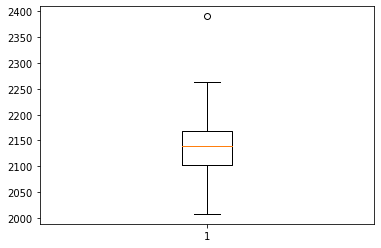

In [4]:
# evaluate lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	data = series_to_supervised(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [36, 50, 100, 100, 12]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('lstm', scores)

At the end of the run, we can see that the average RMSE is about 2,109, which is worse than the naive model. This suggests that the chosen model is not skillful, and it was the best that could be found given the same resources used to find model configurations in the previous sections. This provides further evidence (although weak evidence) that LSTMs, at least alone, are perhaps a bad fit for autoregressive-type sequence prediction problems.

### 14.6.2 CNN LSTM

1. We can combine this capability with the LSTM where a CNN model is applied to sub-sequences of input data, the results of which together form a time series of extracted features that can be interpreted by an LSTM model. This combination of a CNN model used to read multiple subsequences over time by an LSTM is called a CNN-LSTM model. 
2. The model requires that each input sequence, e.g. 36 months, is divided into multiple subsequences, each read by the CNN model, e.g. 3 subsequence of 12 time steps. Therefore, this splitting is parameterized with the n seq and n steps for the number of subsequences and number of steps per subsequence parameters.
3. The number of lag observations per sample is simply (n_seq $\times$ n_steps). This is a 4- dimensional input array now with the dimensions: [samples, subsequences, timesteps, features]. The same CNN model must be applied to each input subsequence. We can achieve this by wrapping the entire CNN model in a TimeDistributed layer wrapper.
4. The output of one application of the CNN submodel will be a vector. The output of the submodel to each input subsequence will be a time series of interpretations that can be interpreted by an LSTM model. 
5. The model expects a list of seven hyperparameters; they are:
   - n_seq: The number of subsequences within a sample.
   - n_steps: The number of time steps within each subsequence.
   - n_filters: The number of parallel filters.
   - n_kernel: The number of time steps considered in each read of the input sequence.
   - n_nodes: The number of LSTM units to use in the hidden layer.
   - n_epochs: The number of times to expose the model to the whole training dataset.
   - n_batch: The number of samples within an epoch after which the weights are updated.

 > 1466.232
 > 1649.687
 > 1953.968
 > 1710.558
 > 1960.039
 > 1719.947
 > 1364.541
 > 1733.133
 > 1365.926
 > 1592.421
 > 1724.963
 > 1843.420
 > 1439.914
 > 1694.081
 > 3730.331
 > 1500.166
 > 1752.941
 > 1608.283
 > 1659.277
 > 1508.029
 > 1581.717
 > 1772.822
 > 1522.565
 > 1569.584
 > 1819.870
 > 2223.411
 > 1558.730
 > 1728.498
 > 1596.333
 > 2022.626
cnn-lstm: 1745.800 RMSE (+/- 414.575)


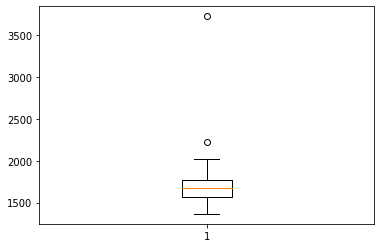

In [5]:
# evaluate cnn-lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
	n_input = n_seq * n_steps
	# prepare data
	data = series_to_supervised(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
	# define model
	model = Sequential()
	model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(None,n_steps,1))))
	model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
	model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_seq, n_steps, _, _, _, _, _ = config
	n_input = n_seq * n_steps
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [3, 12, 64, 3, 100, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)

Running the example prints the RMSE for each repeated evaluation of the model. The final averaged RMSE is reported at the end of about 1,626, which is lower than the naive model, but still higher than a SARIMA model. The standard deviation of this score is also very large, suggesting that the chosen configuration may not be as stable as the standalone CNN model.

## 14.6.3 ConvLSTM

1. It is possible to perform a convolutional operation as part of the read of the input sequence within each LSTM unit. Rather than reading a sequence one step at a time, the LSTM would read a block or subsequence of obvervations at a time using a convolutional process, like a CNN. this is performing the CNN operation at each time step as part of the LSTM.
2. This type of model is called a Convolutional LSTM, or ConvLSTM for short. It is provided in Keras as a layer called ConvLSTM2D for 2D data. We can configure it for use with 1D sequence data by assuming that we have one row with multiple columns. 
3. The output of the layer is a sequence of filter maps that must first be flattened before it can be interpreted and followed by an output layer. The model expects a list of seven hyperparameters, the same as the CNN-LSTM; they are:
   - n_seq: The number of subsequences within a sample.
   - n_steps: The number of time steps within each subsequence.
   - n_filters: The number of parallel filters.
   - n_kernel: The number of time steps considered in each read of the input sequence.
   - n_nodes: The number of LSTM units to use in the hidden layer.
   - n_epochs: The number of times to expose the model to the whole training dataset.
   - n_batch: The number of samples within an epoch after which the weights are updated.

 > 1609.249
 > 1844.314
 > 1612.016
 > 1498.485
 > 1599.419
 > 1902.449
 > 1742.051
 > 2228.348
 > 1268.056
 > 2043.820
 > 2421.004
 > 1844.636
 > 1800.341
 > 1687.433
 > 1357.723
 > 1788.538
 > 2238.601
 > 2027.296
 > 2016.788
 > 1458.253
 > 2117.089
 > 1578.218
 > 1717.727
 > 1746.030
 > 1357.530
 > 2147.564
 > 1706.005
 > 1734.211
 > 2220.085
 > 1698.368
convlstm: 1800.388 RMSE (+/- 284.277)


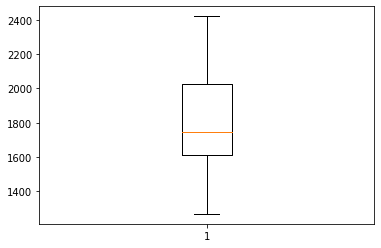

In [8]:
# evaluate convlstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
	# unpack config
	n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
	n_input = n_seq * n_steps
	# prepare data
	data = series_to_supervised(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
	# define model
	model = Sequential()
	model.add(ConvLSTM2D(filters=n_filters, kernel_size=(1,n_kernel), activation='relu', input_shape=(n_seq, 1, n_steps, 1)))
	model.add(Flatten())
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_seq, n_steps, _, _, _, _, _ = config
	n_input = n_seq * n_steps
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [3, 12, 256, 3, 200, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('convlstm', scores)

Running the example prints the RMSE for each repeated evaluation of the model. The final averaged RMSE is reported at the end of about 1,660, which is lower than the naive model, but still higher than a SARIMA model. It is a result that is perhaps on par with the CNN-LSTM model. The standard deviation of this score is also very large, suggesting that the chosen configuration may not be as stable as the standalone CNN model.

## 14.8 Further Reading
This section provides more resources on the topic if you are looking to go deeper.
- pandas.DataFrame.shift API. http://pandas-docs.github.io/pandas-docs-travis/generated/pandas.DataFrame.shift.html
- matplotlib.pyplot.boxplot API. https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html
- Keras Sequential Model API. https://keras.io/models/sequential/
- Keras Core Layers API. https://keras.io/layers/core/
- Keras Convolutional Layers API. https://keras.io/layers/convolutional/
- Keras Pooling Layers API. https://keras.io/layers/pooling/
- Keras Recurrent Layers API. https://keras.io/layers/recurrent/

## 14.9 Summary
In this tutorial, you discovered how to develop a suite of deep learning models for univariate time series forecasting. Specifically, you learned:
- How to develop a robust test harness using walk-forward validation for evaluating the performance of neural network models.
- How to develop and evaluate simple Multilayer Perceptron and convolutional neural networks for time series forecasting.
- How to develop and evaluate LSTMs, CNN-LSTMs, and ConvLSTM neural network models for time series forecasting.